Dorrit0, dorrit1, jelle0, night0, night1

In [1]:
data_path_old = r"C:\Users\Fin Amin\Desktop/\StemCellResearch\datasets_Sahil_preprocessed_final-20220525T021621Z-001\datasets_Sahil_preprocessed_final\exp1"
matrix_path = "regulator-gene-matrix.csv"
data_path = r"C:\Users\Fin Amin\Desktop\StemCellResearch\Fin_preProcessed\synData"
data_path_inter =  r"C:\Users\Fin Amin\Desktop\StemCellResearch\Fin_preProcessed\interpolatedOnly"
data_path_og_exp1 = r"C:\Users\Fin Amin\Desktop\StemCellResearch\Fin_preProcessed\datasets\exp1"


In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import Conv1DTranspose
from keras.layers import Flatten, Reshape

import os
from glob import glob
from tqdm import tqdm

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [4]:
def read_files():
    '''
    *Changed*
    currently hardcoded for only one file. 
    change code a bit for reading multiple files.
    '''
    #genes_intensities_data_matrix = pd.read_csv(file_path_intensities, index_col = 0)
    #print(os.listdir(data_path))
    replicate_files = os.listdir(data_path)
    #print('replicate files:',replicate_files)
    replicates = []
    # i = 0
    for file in replicate_files:
        
        #print('file name:',file)
        #print('value of i:',i)
        genes_intensities_data_matrix = pd.read_csv(os.path.join(data_path , file), index_col = 0, on_bad_lines='skip')
        #print('genes_intensities_data_matrix:',  genes_intensities_data_matrix.head())
        replicates.append(genes_intensities_data_matrix.values)
        # i+=1
        
    genes_intensities_data_matrix = genes_intensities_data_matrix.values
    rgm = np.loadtxt(matrix_path)
    
    return np.asarray(replicates), rgm.astype(np.float32)

In [5]:
replicates, matrix = read_files()

In [6]:
matrix.shape

(245, 245)

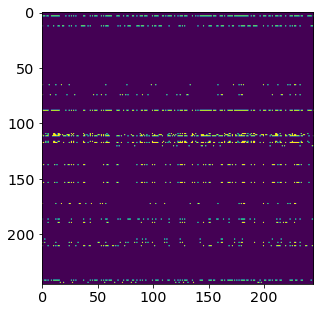

In [7]:
plt.imshow(matrix)

In [8]:
replicates.shape

(6, 6, 245)

In [9]:
#%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [20]:
class EncoderLinear(keras.layers.Layer):
    def __init__(self, rgm, input_dim=32, units=32):
        super(EncoderLinear, self).__init__()
        self.rgm = rgm
        
        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.convert_to_tensor(self.rgm, dtype=dtype)

            return w_init
        

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        return tf.matmul(X, tf.multiply(self.rgm, self.w))
    #tf.matmul(inputs, self.w)

In [297]:
class DecoderLinear(keras.layers.Layer):
    def __init__(self, rgm, input_dim=32, units=32):
        super(DecoderLinear, self).__init__()
        self.rgm = rgm

        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.transpose(tf.convert_to_tensor(self.rgm, dtype=dtype))

            return w_init
    
        
        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        #return tf.matmul(X, tf.multiply((self.rgm), self.w))
        return tf.matmul(X, tf.multiply(tf.transpose(self.rgm), self.w)) #used to have a transpose
        #return tf.matmul(inputs, self.w)

In [298]:
def encoder(parent_child_biological_association, num_hidden_units=2):
    '''
    Encoder structure
    '''
    '''
    The data is time-series. Therefore, CNN to learn the temporal relationship between 
    the intensities for each gene.
    '''
    en_conv = Conv1D(32, 3, activation = "relu")(parent_child_biological_association) # 6*245
    en_dense = Flatten()(en_conv)
    phenotype = Dense(num_hidden_units)(en_dense)
    return phenotype

def decoder(X, num_protein_gene, time_steps):
    '''
    Decoder structure
    '''
    de_dense = Dense(128)(X)
    de_dense = Reshape((1, 128))(de_dense) #tf.reshape(de_dense, (self.batch_size,1,128))
    de_deconv = Conv1DTranspose(num_protein_gene, time_steps, activation = "relu")(de_dense) #used to be transpose
    #de_deconv = Conv1D(num_protein_gene, time_steps, activation = "relu")(de_dense) 
    # gene_reconstruction = self.decoder_biological_operation(de_deconv)
    return de_deconv

def model(rgm, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 2):
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = EncoderLinear(rgm, 245, 245)(inp)
    enc = encoder(x, num_hidden_units)
    dec = decoder(enc, num_protein_gene, time_steps)
    out = DecoderLinear(rgm, 245, 245)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

In [299]:
regulator_gene_matrix =matrix# np.random.randint(0, 2, size=(245, 245)).astype(np.float32)


In [300]:
enc_dec_Synthetic = model(regulator_gene_matrix, 245, 6, 245) #we can just change the time steps to something higher

In [301]:
enc_dec_Synthetic.summary()

Model: "model_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_47 (InputLayer)       [(None, 6, 245)]          0         
                                                                 
 encoder_linear_46 (EncoderL  (None, 6, 245)           60025     
 inear)                                                          
                                                                 
 conv1d_45 (Conv1D)          (None, 4, 32)             23552     
                                                                 
 flatten_44 (Flatten)        (None, 128)               0         
                                                                 
 dense_88 (Dense)            (None, 2)                 258       
                                                                 
 dense_89 (Dense)            (None, 128)               384       
                                                          

In [360]:
from tensorflow.keras import losses

In [516]:
superParent = regulator_gene_matrix.copy()
#print(superParent.shape)

ones = np.ones((245))
parentIndex = []
for i in range(len(regulator_gene_matrix)):
    if (np.isin(regulator_gene_matrix[i], [1])).any():
        #print(i)
        superParent[i] = ones 
        parentIndex.append(i)
parentIndex = np.array(parentIndex)
parentIndex = tf.convert_to_tensor(parentIndex)

def ignore_noParent_MSE(y_true, y_pred):
    l = tf.keras.losses.MeanSquaredError()
    y_true_pruned = tf.gather(y_true, parentIndex)
    #print(y_true_pruned.shape)
    y_pred_pruned = y_pred[:,:,parentIndex]    
    return l(y_true_pruned, y_pred_pruned)

In [517]:
enc_dec_Synthetic.compile(optimizer='adam', loss=ignore_noParent_MSE)

In [518]:
# enc_dec_Synthetic.compile(optimizer='adam',loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True))

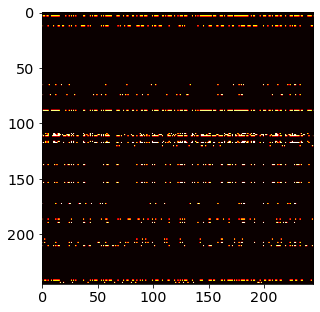

In [519]:
genes_intensities_normalized, regulator_gene_matrix = read_files()
len(regulator_gene_matrix)
plt.imshow(regulator_gene_matrix, cmap = "hot", vmin=0,vmax=1.0)

In [520]:
genes_intensities_normalized[0:].shape

(6, 6, 245)

In [521]:
genes_intensities_normalized[0].shape #30, 246

(6, 245)

In [522]:
ge1 = genes_intensities_normalized[0][0:6]
ge2 = genes_intensities_normalized[0][7:13]
ge = [ge1, ge2]
ge = np.array(ge)

C:\Users\Fin Amin\AppData\Local\Temp\ipykernel_300\2148255341.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ge = np.array(ge)


In [523]:
ge.shape

(2,)

In [524]:
regulator_gene_matrix[0:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [525]:
enc_dec_Synthetic.fit(genes_intensities_normalized[1:],genes_intensities_normalized[1:],epochs=10)

Epoch 1/10


TypeError: in user code:

    File "C:\Users\Fin Amin\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Fin Amin\AppData\Local\Temp\ipykernel_300\1115292162.py", line 18, in ignore_noParent_MSE  *
        y_pred_pruned = y_pred[:,:,parentIndex]

    TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got <tf.Tensor: shape=(21,), dtype=int32, numpy=
    array([  3,  12,  65,  74,  88, 109, 110, 111, 116, 117, 120, 137, 153,
           172, 186, 189, 204, 207, 210, 241, 243])>


In [427]:
w = enc_dec_Synthetic.get_weights()

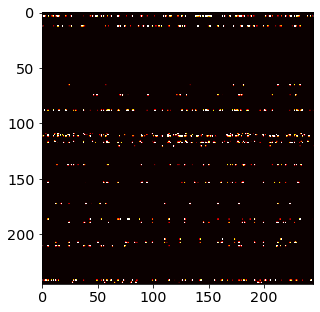

In [314]:
plt.imshow(w[0], cmap = "hot", vmin=0,vmax=0.02)

In [315]:
def getCSVs(data_path_head):
    PATH = data_path_head
    EXT = "*.csv"
    all_csv_files = [file
                     for path, subdir, files in os.walk(PATH)
                     for file in glob(os.path.join(path, EXT))]
    actual = []
    for p in all_csv_files:
        actual.append(pd.read_csv(p, index_col = 0).to_numpy())
    return np.array(actual)
    
exp1_og = getCSVs(data_path_og_exp1)

In [316]:
np.array([genes_intensities_normalized[0]]).shape

(1, 6, 245)

In [317]:
exp1_og[0].shape

(6, 245)

In [318]:
np.array([genes_intensities_normalized[0]]).shape

(1, 6, 245)

In [319]:

outSyn = enc_dec_Synthetic.predict(exp1_og)

1/1 [==============================] - 0s 106ms/step


In [320]:
def mymagn(A, B):
    mse = (np.square(A - B)).mean(axis=None)
    return mse

In [321]:
syntheticLoss = mymagn(outSyn, exp1_og)
syntheticLoss

0.45642797418383674

In [322]:
(outSyn-exp1_og).shape

(4, 6, 245)

In [323]:
def read_filesV2(data_path):
    '''
    *Changed*
    currently hardcoded for only one file. 
    change code a bit for reading multiple files.
    '''
    #genes_intensities_data_matrix = pd.read_csv(file_path_intensities, index_col = 0)
    #print(os.listdir(data_path))
    replicate_files = os.listdir(data_path)
    #print('replicate files:',replicate_files)
    replicates = []
    # i = 0
    for file in replicate_files:
        
        #print('file name:',file)
        #print('value of i:',i)
        genes_intensities_data_matrix = pd.read_csv(os.path.join(data_path , file), index_col = 0, on_bad_lines='skip')
        #print('genes_intensities_data_matrix:',  genes_intensities_data_matrix.head())
        replicates.append(genes_intensities_data_matrix.values)
        # i+=1
        
    genes_intensities_data_matrix = genes_intensities_data_matrix.values
    rgm = np.loadtxt(matrix_path)
    
    return np.asarray(replicates), rgm.astype(np.float32)

In [324]:
interpolated_genes, _ = read_filesV2(data_path_inter)

C:\Users\Fin Amin\AppData\Local\Temp\ipykernel_300\3349346019.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(replicates), rgm.astype(np.float32)


In [325]:
interpolated_genes.shape

(5,)

In [326]:
pd.DataFrame(interpolated_genes[2]).head(5)

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.254943,-1.000000,0.663585,0.440312,-1.000000,0.635664,0.734571,-1.000000,0.312044,0.602692,...,-1.000000,0.400712,-1.000000,0.523033,-1.000000,0.561590,0.403879,0.642049,-1.000000,0.443478
1,0.338509,-1.000000,0.612395,0.655007,-1.000000,-1.000000,0.590564,-1.000000,0.353872,0.539972,...,-1.000000,0.445519,-1.000000,0.586067,-1.000000,0.541903,0.426403,0.495559,0.550973,0.419991
2,-1.000000,0.544463,0.596307,0.596367,-1.000000,0.629406,0.579586,0.726602,-1.000000,0.535278,...,0.509166,-1.000000,-1.000000,0.642262,-1.000000,0.586480,0.569283,-1.000000,0.596188,-1.000000
3,-0.329754,-0.454583,-0.828393,0.582746,-0.689224,0.178233,0.309607,-0.297329,-0.461788,0.493608,...,-0.024981,-0.697509,-0.153204,0.546957,0.161868,0.291320,-0.109625,-0.444279,0.007077,-0.254379
4,-1.000000,0.528085,-1.000000,0.523557,-1.000000,0.588043,0.580612,-1.000000,0.354997,0.567674,...,0.573489,0.392001,-1.000000,0.602732,-1.000000,0.544163,0.423905,-1.000000,0.578650,-1.000000


In [327]:
inter = []
for k in range(len(interpolated_genes)):
    #print(k)
    if k == 2 or k == 3 or k == 4:
        inter.append(np.reshape(interpolated_genes[k], (4,6,245)))
    else: 
        inter.append(np.reshape(interpolated_genes[k], (5,6,245)))
inter = np.vstack(inter)

In [328]:
inter.shape

(22, 6, 245)

In [329]:
genes_intensities_normalized[1:].shape

(5, 6, 245)

In [330]:
enc_dec_inter = model(regulator_gene_matrix, 245, 6, 245) 
enc_dec_inter.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [331]:
enc_dec_inter.fit(inter, inter,epochs=10);

Epoch 1/10
1/1 [==============================] - 1s 912ms/step - loss: 0.4634
Epoch 2/10
1/1 [==============================] - 0s 13ms/step - loss: 0.4631
Epoch 3/10
1/1 [==============================] - 0s 16ms/step - loss: 0.4625
Epoch 4/10
1/1 [==============================] - 0s 16ms/step - loss: 0.4613
Epoch 5/10
1/1 [==============================] - 0s 16ms/step - loss: 0.4592
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.4558
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.4507
Epoch 8/10
1/1 [==============================] - 0s 16ms/step - loss: 0.4434
Epoch 9/10
1/1 [==============================] - 0s 16ms/step - loss: 0.4338
Epoch 10/10
1/1 [==============================] - 0s 16ms/step - loss: 0.4223


In [493]:
outInter = enc_dec_inter.predict(exp1_og)
interpolationLoss = ignore_noParent_MSE(outInter, exp1_og)

1/1 [==============================] - 0s 17ms/step
(4, 6, 21)


In [494]:
interpolationLoss

<tf.Tensor: shape=(), dtype=float64, numpy=0.4363467321512668>

In [408]:
outInter.shape

(4, 6, 245)

In [333]:
u = enc_dec_inter.history
u

In [405]:
interpolationLoss

0.4651538254553579

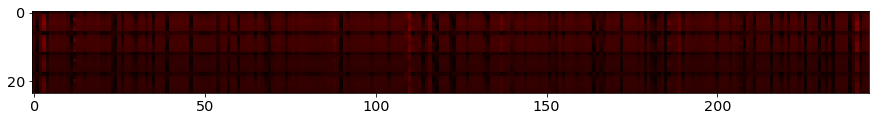

In [336]:
u = plt.imshow(np.reshape((np.abs(outSyn)), (24,245)), cmap = "hot", vmin=0,vmax=1.0 );

In [337]:
u = pd.DataFrame(outSyn[0])
u.head(10)

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,-0.059708,0.051970,0.055281,0.010215,-0.006730,-0.059439,0.047572,-0.059539,0.042227,0.060057,...,0.058970,-0.059203,-0.058365,0.057307,0.035403,-0.057158,0.068602,-0.030201,0.054157,0.056546
1,-0.091623,0.047231,0.085759,0.134655,0.033597,-0.090682,0.086435,-0.089146,0.080547,0.090031,...,0.089225,-0.089862,-0.088490,0.089817,0.027676,-0.083249,0.122342,0.007750,0.085288,0.089169
2,-0.098118,0.035013,0.092587,0.159541,0.051219,-0.097518,0.095435,-0.095595,0.091150,0.096518,...,0.095154,-0.096416,-0.095101,0.097045,0.016857,-0.086341,0.126279,0.028944,0.085470,0.096163
3,-0.100493,0.024838,0.095101,0.179741,0.065212,-0.099747,0.098196,-0.097498,0.094648,0.098482,...,0.097567,-0.098725,-0.097372,0.099368,0.010669,-0.087211,0.176531,0.047004,0.092356,0.098749
4,-0.093019,0.009822,0.088547,0.161521,0.068953,-0.092539,0.091451,-0.090370,0.088639,0.091284,...,0.090341,-0.091672,-0.090428,0.092266,0.001156,-0.078438,0.158102,0.056780,0.093035,0.091591
5,-0.089457,-0.001075,0.085302,0.136045,0.068154,-0.089078,0.087947,-0.086843,0.085327,0.087743,...,0.086867,-0.088219,-0.087047,0.088815,-0.008606,-0.073274,0.169764,0.061464,0.074215,0.088121


In [338]:
u = pd.DataFrame(exp1_og[0])
u.head(10)

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.545768,0.703299,0.515768,0.311232,0.603906,0.450516,0.485420,-1.000000,0.530434,0.572562,...,-1.000000,-1.000000,-1.000000,-1.000000,0.555532,0.541632,0.654674,0.388019,0.595213,0.494394
1,0.571387,0.671613,0.496906,0.476887,0.518088,0.460362,0.533427,0.339136,0.503110,0.512354,...,-1.000000,0.535256,0.287251,0.287251,0.469841,0.466546,0.570334,0.629295,0.587421,0.491340
2,0.573213,0.659692,-1.000000,0.287767,0.482881,0.573876,0.511186,-1.000000,0.554230,0.491498,...,-1.000000,0.514596,0.319856,0.319856,0.499579,0.408823,0.643895,0.608160,0.558828,0.550060
3,0.719028,0.619979,0.511423,0.440943,0.553337,0.538648,0.516070,-1.000000,0.581957,0.511349,...,0.725449,0.526762,0.378214,0.378214,0.536969,0.488291,0.679073,0.666191,0.593245,0.472189
4,0.754752,0.575484,0.516054,0.478201,0.531809,0.492656,0.538193,-1.000000,0.573013,0.531139,...,0.842432,0.607337,-1.000000,-1.000000,0.542545,0.519905,0.627382,0.668263,-1.000000,-1.000000
5,0.854373,0.601120,0.488601,0.647987,0.477734,0.534696,0.476710,0.424972,0.485754,0.461551,...,0.407374,0.612411,0.309963,0.309963,0.484060,0.585643,0.667441,0.700049,0.564833,0.480564


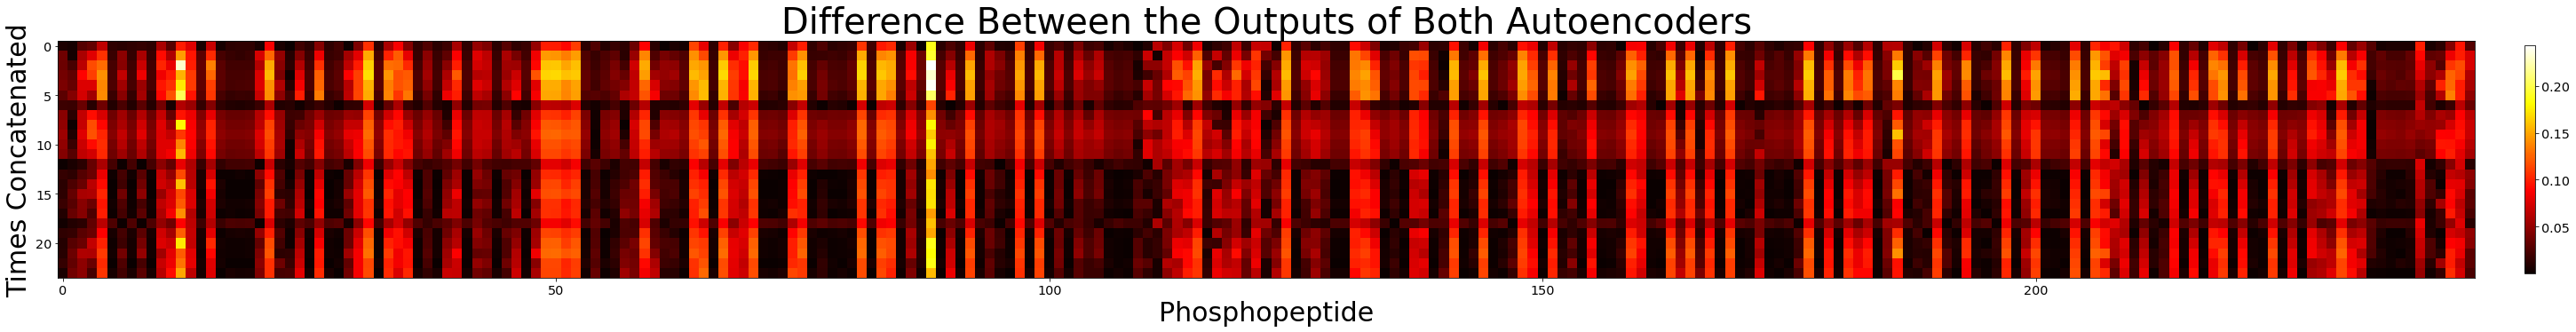

In [339]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape((np.abs(outSyn-outInter)), (24,245)), cmap = "hot")#, vmin=0,vmax=1.0 );
plt.title("Difference Between the Outputs of Both Autoencoders", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30);
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("DiffBetweenOut.png")

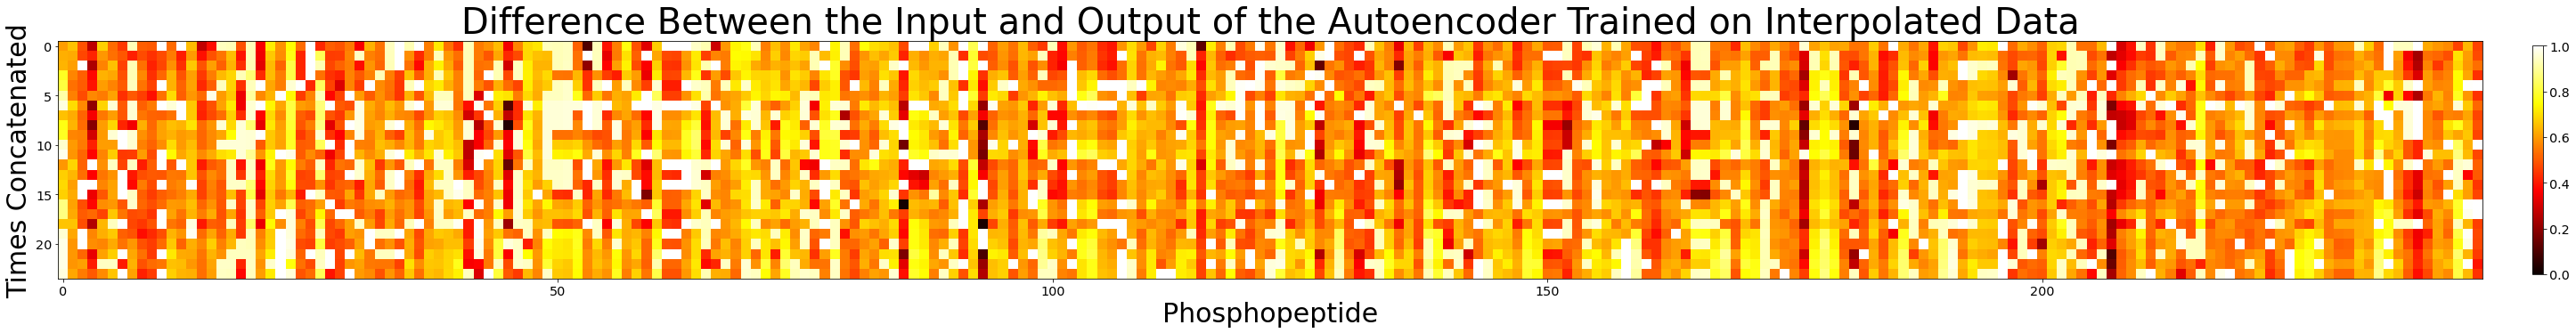

In [340]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape(np.abs(outInter-exp1_og), (24,245)) , cmap = "hot", vmin=0,vmax=1.0 )
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Interpolated Data", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30)
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02)
#plt.savefig("InterDiffImage.png")

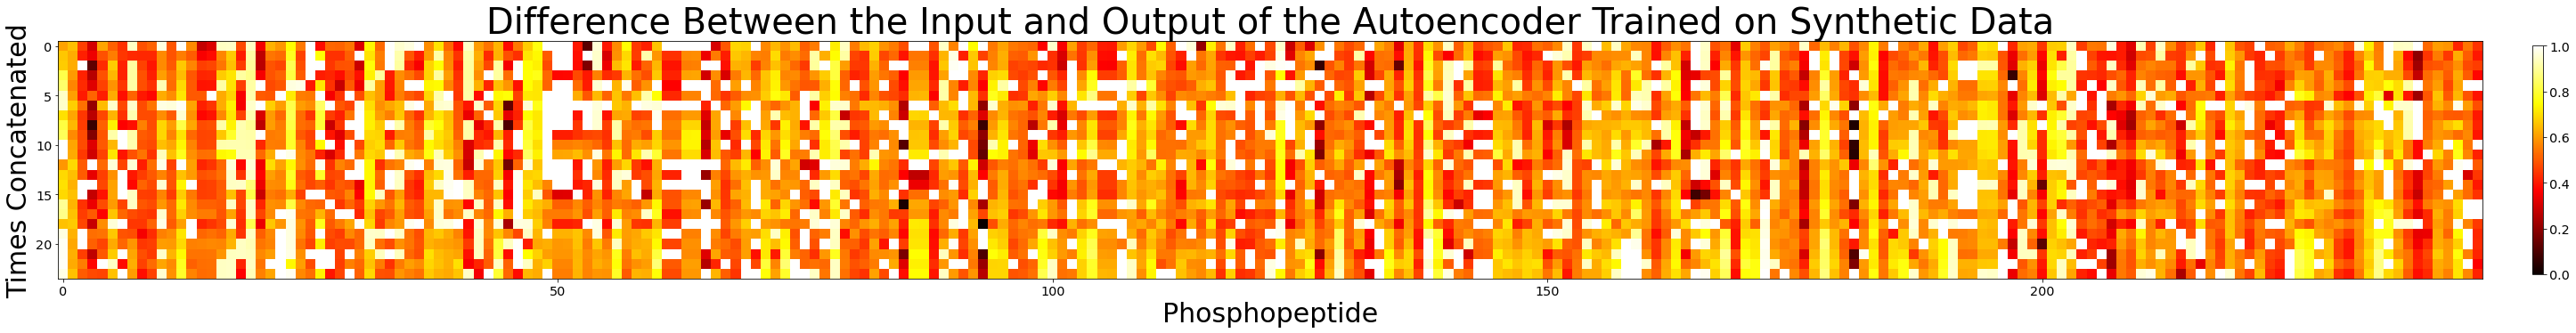

In [341]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape(np.abs(outSyn-exp1_og), (24,245)), cmap = "hot", vmin=0,vmax=1.0 )
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Synthetic Data", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30);
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("SynDiffImage.png");

In [342]:
u = pd.DataFrame(np.reshape(np.abs(outSyn), (24,245)))
u.head()

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.059708,0.051970,0.055281,0.010215,0.006730,0.059439,0.047572,0.059539,0.042227,0.060057,...,0.058970,0.059203,0.058365,0.057307,0.035403,0.057158,0.068602,0.030201,0.054157,0.056546
1,0.091623,0.047231,0.085759,0.134655,0.033597,0.090682,0.086435,0.089146,0.080547,0.090031,...,0.089225,0.089862,0.088490,0.089817,0.027676,0.083249,0.122342,0.007750,0.085288,0.089169
2,0.098118,0.035013,0.092587,0.159541,0.051219,0.097518,0.095435,0.095595,0.091150,0.096518,...,0.095154,0.096416,0.095101,0.097045,0.016857,0.086341,0.126279,0.028944,0.085470,0.096163
3,0.100493,0.024838,0.095101,0.179741,0.065212,0.099747,0.098196,0.097498,0.094648,0.098482,...,0.097567,0.098725,0.097372,0.099368,0.010669,0.087211,0.176531,0.047004,0.092356,0.098749
4,0.093019,0.009822,0.088547,0.161521,0.068953,0.092539,0.091451,0.090370,0.088639,0.091284,...,0.090341,0.091672,0.090428,0.092266,0.001156,0.078438,0.158102,0.056780,0.093035,0.091591


In [343]:
# np.save("interpolated_.npy", inter) #the interpolated dataset
# np.save("synthetic_.npy", genes_intensities_normalized[1:]) # the synthetic dataset
# np.save("synOut.npy", outSyn) #the output of the encoder trained on synthetic data with the input being exp1
# np.save("interOut.npy", outInter) #the output of the encoder trained on interpolated data with the input being exp1

In [344]:
inter.shape

(22, 6, 245)

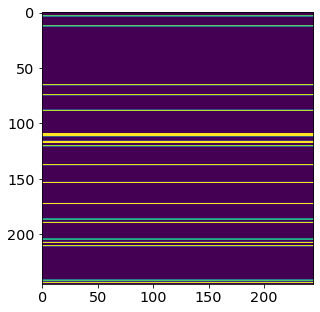

In [347]:
plt.imshow(superParent)

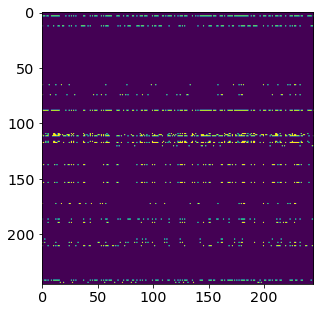

In [348]:
plt.imshow(regulator_gene_matrix)

In [349]:
looseParent = model(superParent, 245, 6, 245, 2)
looseParent.compile(optimizer='adam', loss=losses.MeanSquaredError())
looseParent.fit(genes_intensities_normalized, genes_intensities_normalized, epochs=10)

Epoch 1/10
1/1 [==============================] - 1s 505ms/step - loss: 0.5630
Epoch 2/10
1/1 [==============================] - 0s 21ms/step - loss: 0.5622
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.5603
Epoch 4/10
1/1 [==============================] - 0s 8ms/step - loss: 0.5562
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.5487
Epoch 6/10
1/1 [==============================] - 0s 16ms/step - loss: 0.5367
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.5182
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.4919
Epoch 9/10
1/1 [==============================] - 0s 16ms/step - loss: 0.4567
Epoch 10/10
1/1 [==============================] - 0s 8ms/step - loss: 0.4134


In [350]:
hidden = [2,4,8,16,32] #range(1,32)
networks = []
for value in tqdm(hidden):
    looseParent = model(superParent, 245, 6, 245, value)
    looseParent.compile(optimizer='adam', loss=losses.MeanSquaredError())
    looseParent.fit(genes_intensities_normalized, genes_intensities_normalized, epochs=40,  verbose=0)
    networks.append(looseParent)


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.29it/s]


In [351]:
loss = []
hm = []
for net in networks:
    test = net.predict(exp1_og)
    l = mymagn(test, exp1_og)
    loss.append(l)
    hm.append(test)

1/1 [==============================] - 0s 94ms/step


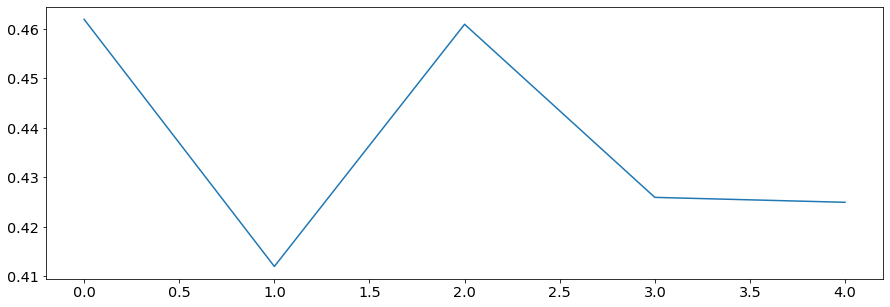

In [352]:
plt.plot(loss)

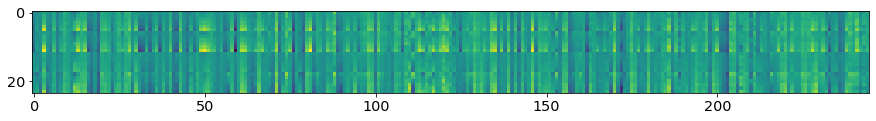

In [353]:
u = np.reshape(hm[-1], (24,245))

plt.imshow(u)

In [355]:
u = pd.DataFrame(u)
u.head()

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,-0.160350,-0.112686,0.024361,0.157597,0.064283,-0.075060,0.158631,-0.217863,-0.034932,0.290576,...,-0.030266,-0.203758,-0.151552,0.102979,0.430362,0.276036,0.317487,-0.068831,0.045984,0.167377
1,-0.129125,-0.016801,-0.029578,0.279523,-0.006059,-0.070852,0.162942,-0.167830,0.019320,0.242410,...,0.034044,-0.171489,-0.120659,0.166527,0.325349,0.232296,0.305695,0.003004,0.219846,0.129892
2,-0.195013,-0.011052,-0.044940,0.307142,0.012813,-0.086256,0.197004,-0.133987,0.069531,0.214334,...,0.063319,-0.183092,-0.105500,0.245251,0.253330,0.179713,0.475512,0.075182,0.210454,0.142940
3,-0.228372,0.017833,-0.104185,0.424143,-0.051326,-0.073273,0.251955,-0.177135,0.082215,0.298880,...,0.129133,-0.276612,-0.142201,0.342589,0.373235,0.223663,0.564211,0.060548,0.293248,0.162668
4,-0.274633,0.081415,-0.114905,0.702136,-0.099177,-0.149704,0.284541,-0.159696,0.152225,0.292782,...,0.184340,-0.250005,-0.127390,0.435843,0.278185,0.151557,0.421315,0.122881,-0.018982,0.164553


In [354]:
v = np.reshape(exp1_og, (24,245))
v = pd.DataFrame(v)
v.head()

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.545768,0.703299,0.515768,0.311232,0.603906,0.450516,0.485420,-1.000000,0.530434,0.572562,...,-1.000000,-1.000000,-1.000000,-1.000000,0.555532,0.541632,0.654674,0.388019,0.595213,0.494394
1,0.571387,0.671613,0.496906,0.476887,0.518088,0.460362,0.533427,0.339136,0.503110,0.512354,...,-1.000000,0.535256,0.287251,0.287251,0.469841,0.466546,0.570334,0.629295,0.587421,0.491340
2,0.573213,0.659692,-1.000000,0.287767,0.482881,0.573876,0.511186,-1.000000,0.554230,0.491498,...,-1.000000,0.514596,0.319856,0.319856,0.499579,0.408823,0.643895,0.608160,0.558828,0.550060
3,0.719028,0.619979,0.511423,0.440943,0.553337,0.538648,0.516070,-1.000000,0.581957,0.511349,...,0.725449,0.526762,0.378214,0.378214,0.536969,0.488291,0.679073,0.666191,0.593245,0.472189
4,0.754752,0.575484,0.516054,0.478201,0.531809,0.492656,0.538193,-1.000000,0.573013,0.531139,...,0.842432,0.607337,-1.000000,-1.000000,0.542545,0.519905,0.627382,0.668263,-1.000000,-1.000000


In [294]:
networks[-1]

In [ ]:
#re-write loss function to only calculate on 1s

In [358]:
k = np.array([4,5,6,7,8])
f = np.array([0,2])
print(k[f])

[4 6]


NameError: name 'interOut' is not defined

In [414]:

z = outInter[:,:,parentIndex]

In [416]:
z.shape

(4, 6, 21)